# ConvenienceKinetics Fitting

In [1]:
import projectpath

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from mosmo.knowledge import kb
from mosmo.knowledge.thermo import Thermodynamics
from mosmo.model import KbEntry, DbXref, Molecule, Reaction, ReactionNetwork
from mosmo.sim.convenience_kinetics import ConvenienceKinetics, Ligands, ReactionKinetics, PackedNetworkKinetics

jax.config.update('jax_enable_x64', True)

KB = kb.configure_kb()
thermo = Thermodynamics(p_h=7.3, p_mg=1.5, ionic_strength=0.25, temperature=298.15)

## A Couple enzymes from glycolysis
- Initial kinetic constants set from Brenda
- Adjusted kcats to fit thermodynamic constraints

In [2]:
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
pgi = glycolysis.steps[0]
pfk = glycolysis.steps[1]
g6p = KB('Glc.D.6P')
f6p = KB('Fru.D.6P')

pgi_dg = thermo.reaction_delta_g(pgi)
pfk_dg = thermo.reaction_delta_g(pfk)

print(f'[{pgi.id}] {pgi.formula} : ΔG = {pgi_dg}')
print(f'[{pfk.id}] {pfk.formula} : ΔG = {pfk_dg}')

concs = {KB(met_id): conc for met_id, conc in [
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.6P', 7.88),
    ('adp', 5.55e-01),
    ('atp', 9.63),
    ('h+', 1e-4),
    ('h2o', 1000.0),  # Activity of the solvent is defined as 1 (M?)
]}

kinetics = {
    pgi: ReactionKinetics(kcat_f=1, kcat_b=1, km={g6p: 0.28, f6p: 0.147}, ka={}, ki={}),
    pfk: ReactionKinetics(kcat_f=60, kcat_b=1, km={f6p: 0.1, KB('atp'): 0.15, KB('adp'): 0.1}, ka={}, ki={KB('atp'): 10.}),  # edited Ki for ATP
}

network = ReactionNetwork([pgi, pfk])
ck = ConvenienceKinetics(network, kinetics)
# Manually choose kv to get close to the configured kcat_f for pfk.
ck.adjust_kinetics(np.array([pgi_dg, pfk_dg]), np.array([0., -0.52]))
ck.kparms

[pgi] G6P <=> F6P : ΔG = -0.049859255775004385
[pfk] ATP + F6P => ADP + F16bP + H+ : ΔG = -16.177938426490925


PackedNetworkKinetics(kcats_f=DeviceArray([ 1.39408043, 60.16425292], dtype=float64), kcats_b=DeviceArray([0.71731873, 0.00587483], dtype=float64), kms_s=DeviceArray([[0.28, 1.  ],
             [0.15, 0.1 ]], dtype=float64), kms_p=DeviceArray([[0.147, 1.   , 1.   ],
             [0.1  , 0.1  , 0.1  ]], dtype=float64), kas=DeviceArray([], dtype=float64), kis=DeviceArray([[ 1.],
             [10.]], dtype=float64))

## (Initial) Velocity vs Substrate Concentration

In [3]:
def substrate_velocity_state(network, substrate, min_conc=0.01, max_conc=100, num_assays=20, other_concs=None):
    background = network.reactants.pack(other_concs or {})
    substrate_range = jnp.exp(jnp.linspace(jnp.log(min_conc), jnp.log(max_conc), num_assays))
    return jnp.tile(background, [num_assays, 1]).at[:, network.reactants.index_of(substrate)].set(substrate_range)

### PFK V vs S
#### S = F6P

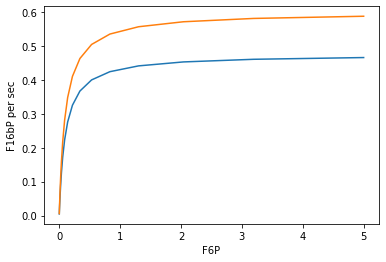

In [4]:
pfk_enzyme = network.reactions.pack({pfk: 0.01})
fn = lambda state: ck.dstate_dt(state, pfk_enzyme)
vfn = jax.vmap(fn)
substrate = f6p
product = KB('Fru.D.bis16')
states = substrate_velocity_state(network, substrate, min_conc=1e-3, max_conc=5, other_concs={KB('atp'): 1})
dstate_dt = vfn(states)

s_range = states[:, network.reactants.index_of(substrate)]
v_result = dstate_dt[:, network.reactants.index_of(product)]

plt.plot(s_range, v_result)
plt.plot(s_range, 0.01 * 60 * s_range / (s_range + 0.1))
plt.xlabel(substrate.label)
plt.ylabel(product.label + " per sec")
plt.show()

- Not full strength because of substrate inhibition. So, working as intended.

#### S = ATP

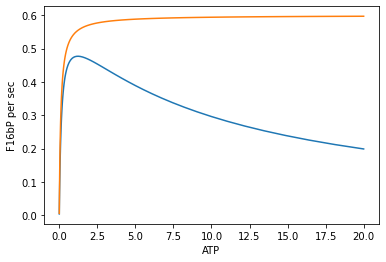

In [5]:
substrate = KB('atp')
product = KB('Fru.D.bis16')
states = substrate_velocity_state(network, substrate, min_conc=1e-3, max_conc=20, other_concs={f6p: 100}, num_assays=101)
dstate_dt = vfn(states)

s_range = states[:, network.reactants.index_of(substrate)]
v_result = dstate_dt[:, network.reactants.index_of(product)]

plt.plot(s_range, v_result)
plt.plot(s_range, 0.01 * 60 * s_range / (s_range + 0.1))
plt.xlabel(substrate.label)
plt.ylabel(product.label + " per sec")
plt.show()

Substrate inhibition in action
- Importantly, this means flux through glycolysis increases ~proportionally as [ATP] decreasees near the physiological range of ~10 mM, which is exactly the point

### PGI V vs S
- S = G6P
- S = F6P (reverse)

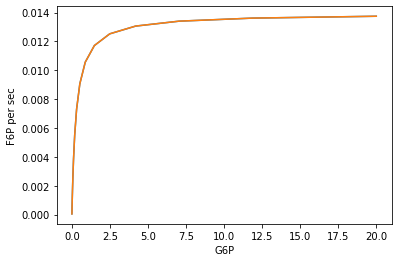

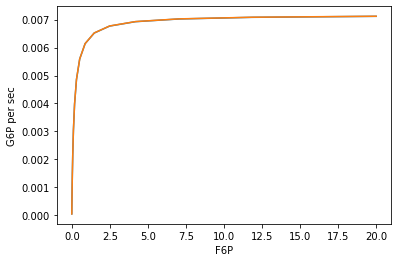

In [6]:
fn = lambda state: ck.dstate_dt(state, network.reactions.pack({pgi: 0.01}))
vfn = jax.vmap(fn)

substrate = g6p
product = f6p
states = substrate_velocity_state(network, substrate, min_conc=1e-3, max_conc=20)
dstate_dt = vfn(states)

s_range = states[:, network.reactants.index_of(substrate)]
v_result = dstate_dt[:, network.reactants.index_of(product)]

plt.plot(s_range, 0.01 * 1.394 * s_range / (s_range + 0.28))
plt.plot(s_range, v_result)
plt.xlabel(substrate.label)
plt.ylabel(product.label + " per sec")
plt.show()

product = g6p
substrate = f6p
states = substrate_velocity_state(network, substrate, min_conc=1e-3, max_conc=20)
dstate_dt = vfn(states)

s_range = states[:, network.reactants.index_of(substrate)]
v_result = dstate_dt[:, network.reactants.index_of(product)]

plt.plot(s_range, 0.01 * 0.717 * s_range / (s_range + 0.147))
plt.plot(s_range, v_result)
plt.xlabel(substrate.label)
plt.ylabel(product.label + " per sec")
plt.show()

## Find Steady State in a 2-reaction System
- F6P is the only variable; everything else is as given

In [7]:
def ss_residual_fn(concs, enzymes, internals):
    state = jnp.asarray(network.reactants.pack(concs))
    enzyme_concs = jnp.asarray(network.reactions.pack(enzymes))
    var_idx = np.array([network.reactants.index_of(mol) for mol in internals])

    def ss_residual(x):
        dydt = ck.dstate_dt(state.at[var_idx].set(x), enzyme_concs)
        return dydt[var_idx]
    
    return ss_residual


In [8]:
fn = ss_residual_fn(concs, {pgi: 0.01, pfk: 0.01}, [f6p])
ss = scipy.optimize.least_squares(
    fun=jax.jit(fn),
    x0 = jnp.array([concs[f6p]]),
    jac=jax.jit(jax.jacfwd(fn))
)
print(f'Steady state [F6P] = {ss.x}, with residual dy/dt = {ss.fun}')
rates = ck.reaction_rates(jnp.asarray(network.reactants.pack(concs)).at[network.reactants.index_of(f6p)].set(ss.x[0]),
                          jnp.asarray(network.reactions.pack({pgi: 0.01, pfk: 0.01})))
print(f'Velocities:')
for rxn, v in zip(network.reactions, rates):
    print(f'  {rxn.label}: {v}')

Steady state [F6P] = [0.07434658], with residual dy/dt = [3.36565498e-12]
Velocities:
  PGI: 0.013110431732100743
  PFK: 0.01311043172873509


### Steady state [F6P] as a function of [PGI] with [PFK] constant

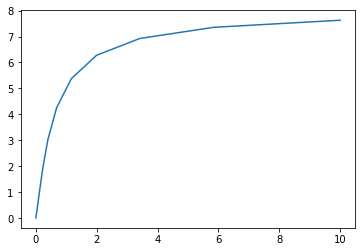

In [9]:
min_conc = 1e-6  # 1 nM = 1 per cell
max_conc = 10.0  # 10 mM = 1e7 per cell
num_assays = 31
pgi_range = jnp.exp(jnp.linspace(jnp.log(min_conc), jnp.log(max_conc), num_assays))

results = []
residuals = []
for pgi_conc in pgi_range:
    fn = ss_residual_fn(concs, {pgi: pgi_conc, pfk: 0.01}, [f6p])
    ss = scipy.optimize.least_squares(
        fun=jax.jit(fn),
        x0 = jnp.array([concs[f6p]]),
        jac=jax.jit(jax.jacfwd(fn))
    )

    results.append(ss.x[0])
    residuals.append(ss.fun[0])

plt.plot(pgi_range, results)
plt.show()

PFK is limiting at high PGI; F6P approaches equilibrium with respect to G6P.

### Steady-State F6P as a function of [PFK] with [PGI] constant

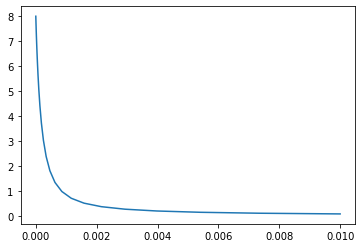

In [10]:
min_conc = 1e-6  # 1 nM = 1 per cell
max_conc = 0.01  # 0.01 mM = 1e4 per cell
num_assays = 31
pfk_range = jnp.exp(jnp.linspace(jnp.log(min_conc), jnp.log(max_conc), num_assays))

results = []
residuals = []
for pfk_conc in pfk_range:
    fn = ss_residual_fn(concs, {pgi: 0.01, pfk: pfk_conc}, [f6p])
    ss = scipy.optimize.least_squares(
        fun=jax.jit(fn),
        x0 = jnp.array([concs[f6p]]),
        jac=jax.jit(jax.jacfwd(fn))
    )

    results.append(ss.x[0])
    residuals.append(ss.fun[0])

plt.plot(pfk_range, results)
plt.show()

PGI is limiting at high PFK; F6P crashes

### Fix kinetics and metabolite concentrations, then fit enzyme concentrations
#### 1. For PGI + PFK
- Hey, maybe we can reuse some of the fba_gd objectives as-is

In [11]:
from mosmo.sim.fba_gd import SteadyStateObjective, ProductionObjective, VelocityObjective

In [12]:
ck = ConvenienceKinetics(network, kinetics)  # Fixed
kinetic_params = ck.kparms
state = jnp.asarray(network.reactants.pack(concs))  # Fixed

enzyme_concs = jnp.asarray(network.reactions.pack({pgi: 0.001, pfk: 0.001}))  # Variable, initial 1000 per cell
objectives = {
    'steadystate': SteadyStateObjective(network, [f6p])
}

# Ripped straight from fba_gd.py
def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) for objective, p in zip(objectives.values(), params)])

# But velocity vector v is not the variable being optimized; instead we get it from ck.reaction_rates()
def fn(enzyme_concs):
    v = ck.reaction_rates(state, enzyme_concs, kinetic_params)
    return residual(v, [None])

In [13]:
soln = scipy.optimize.least_squares(
    fun=jax.jit(fn),
    jac=jax.jit(jax.jacfwd(fn)),
    x0=enzyme_concs,
)

soln_concs = soln.x
soln_rates = ck.reaction_rates(state, soln_concs)
soln_dconcdt = network.s_matrix @ soln_rates

print(f'Succes = {soln.success}, residual = {np.sum(np.square(soln.fun))}')
print(f'Steady state reactions:')
for rxn, econc, rate in zip(network.reactions, soln_concs, soln_rates):
    print(f'{rxn.label:>10} [{econc:.6f} mM]: {rate:.2e} mM/sec')
print()
print('Steady state metabolites:')
for reactant, conc, dconcdt in zip(network.reactants, state, soln_dconcdt):
    print(f'{reactant.label:>10}: {conc} mM ({dconcdt:+.2e} mM/sec)')


Succes = True, residual = 2.3512457867945755e-20
Steady state reactions:
       PGI [0.001013 mM]: 2.41e-04 mM/sec
       PFK [0.000013 mM]: 2.41e-04 mM/sec

Steady state metabolites:
       G6P: 7.88 mM (-2.41e-04 mM/sec)
       F6P: 2.52 mM (+1.53e-10 mM/sec)
       ATP: 9.63 mM (-2.41e-04 mM/sec)
       ADP: 0.555 mM (+2.41e-04 mM/sec)
     F16bP: 15.2 mM (+2.41e-04 mM/sec)
        H+: 0.0001 mM (+2.41e-04 mM/sec)


In [14]:
# Only adjust one of the enzymes.
def fn(x):
    # Arbitrarily adjust the first enzyme
    v = ck.reaction_rates(state, enzyme_concs.at[0].set(x[0]), kinetic_params)
    return residual(v, [None])

soln = scipy.optimize.least_squares(
    fun=jax.jit(fn),
    jac=jax.jit(jax.jacfwd(fn)),
    x0=jnp.array([0.001]),
)

soln_concs = enzyme_concs.at[0].set(soln.x[0])
soln_rates = ck.reaction_rates(state, soln_concs)
soln_dconcdt = network.s_matrix @ soln_rates

print(f'Succes = {soln.success}, residual = {np.sum(np.square(soln.fun))}')
print(f'Steady state reactions:')
for rxn, econc, rate in zip(network.reactions, soln_concs, soln_rates):
    print(f'{rxn.label:>10} [{econc:.6f} mM]: {rate:.2e} mM/sec')
print()
print('Steady state metabolites:')
for reactant, conc, dconcdt in zip(network.reactants, state, soln_dconcdt):
    print(f'{reactant.label:>10}: {conc} mM ({dconcdt:+.2e} mM/sec)')


Succes = True, residual = 0.0
Steady state reactions:
       PGI [0.076769 mM]: 1.82e-02 mM/sec
       PFK [0.001000 mM]: 1.82e-02 mM/sec

Steady state metabolites:
       G6P: 7.88 mM (-1.82e-02 mM/sec)
       F6P: 2.52 mM (+3.47e-18 mM/sec)
       ATP: 9.63 mM (-1.82e-02 mM/sec)
       ADP: 0.555 mM (+1.82e-02 mM/sec)
     F16bP: 15.2 mM (+1.82e-02 mM/sec)
        H+: 0.0001 mM (+1.82e-02 mM/sec)


#### 2. For full glycolysis
- Taller order -- need to collect all that kinetic data